In [1]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
import os

load_dotenv()
def set_env_vars(var):
    os.environ[var] = os.getenv(var)


vars = ["OPENAI_API_KEY", "LANGCHAIN_API_KEY", "LANGCHAIN_TRACING_V2", "LANGCHAIN_ENDPOINT", "LANGCHAIN_PROJECT", "TAVILY_API_KEY"]

for var in vars:
    set_env_vars(var)

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [2]:
import nest_asyncio
nest_asyncio.apply()


In [12]:
from typing import List, Optional
from typing_extensions import TypedDict

from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage

from playwright.async_api import Page

class BBox(TypedDict):
    x: float
    y: float
    text: str
    type: str
    ariaLabel: str

class Prediction(TypedDict):
    action: str
    args: Optional[List[str]]

class AgentState(TypedDict):
    page: Page
    input: str
    img: str #base64 encoded screenshot
    bboxes: List[BBox]
    prediction: Prediction
    scratchpad: List[BaseMessage]
    observation: str
    




## Tools
1. Click (at labelled box)
2. Type
3. Scroll
4. Wait
5. Go back
6. Go to search engine (Google)



In [5]:
import asyncio
import platform

async def click(state: AgentState):
    page = state["page"]
    click_args = state["prediction"]["args"]
    if click_args is None or len(click_args) != 1:
        return f"Failed to click bounding box labeled as number {click_args}"
    bbox_id = click_args[0]
    bbox_id = int(bbox_id)
    try:
        bbox = state["bboxes"][bbox_id]
    except Exception:
        return f"Error: no box for : {bbox_id}"
    await page.mouse.click(bbox["x"], bbox["y"])
    return f"Clicked on {bbox_id}"


async def type_text(state: AgentState):
    page = state["page"]
    type_args = state["predcition"]["args"]
    if type_args is None or len(type_args) != 2:
        return (f"Failed to type in element from bounding box labeled as number {type_args}")
    bbox_id = type_args[0]
    bbox_id = int(bbox_id)
    bbox = state["bboxes"][bbox_id]
    x,y = bbox["x"], bbox["y"]
    text_content = type_args[1]

    await page.mouse.click(x,y)
    select_all = "Meta+A" if platform.system() == "Darwin" else "Control+A"
    await page.keyboard.press(select_all)
    await page.keyboard.press("Backspace")
    await page.keyboard.type(text_content)
    return f"Typed {text_content} into {bbox_id}"

async def scroll(state:AgentState):
    page = state["page"]
    scroll_args = state["prediction"]["args"]
    if scroll_args is None or len(scroll_args) != 2:
        return f"Failed to scroll due to incorrect arguments"
    target, direction = scroll_args
    if target.upper() == "WINDOW":
        scroll_amount =500
        scroll_direction = (-scroll_amount if direction.lower() == "up" else scroll_amount)
        await page.evaluate(f"window.scrollBy(0, {scroll_direction})")
    else:
        scroll_amount = 200
        target_id = int(target)
        bbox = state["bboxes"][target_id]
        x,y = bbox["x"], bbox["y"]
        scroll_direction = (-scroll_amount if direction.lower() == "up" else scroll_amount)
        await page.mouse.move(x,y)
        await page.mouse.wheel(0, scroll_direction)
    return f"Scrolled {direction} in {'window' if target.upper() == 'WINDOW' else f'element {target_id}'}"

async def wait(state: AgentState):
    sleep_time = 5
    await asyncio.sleep(sleep_time)
    return f"Waited for {sleep_time}s"

async def go_back(state:AgentState):
    page= state["page"]
    await page.go_back()
    return f"Navigated back a page to {page.url}."

async def to_google(state:AgentState):
    page = state["page"]
    await page.goto("https://www.google.com")
    return f"Navigated to Google."


In [18]:
import base64
from langchain_core.runnables import chain as chain_decorator

with open("mark_page.js") as f:
    mark_page_script = f.read()

@chain_decorator
async def mark_page(page):
    await page.evaluate(mark_page_script)
    for _ in range (10):
        try: 
            bboxes = await page.evaluate("markPage()")
            break
        except Exception:
            asyncio.sleep(3)
    screenshot = await page.screenshot()
    await page.evaluate("unmarkPage()")
    return {
        "img" : base64.b64encode(screenshot).decode(),
        "bboxes" : bboxes,
    }



In [31]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_openai import ChatOpenAI

async def annotate(state):
    marked_page = await mark_page.with_retry().ainvoke(state["page"])
    return {**state, **marked_page}

def format_description(state):
    labels = []
    for i, bbox in enumerate(state["bboxes"]):
        text = bbox.get("ariaLabel", "")
        if not text.strip():
            text = bbox["text"]
            el_type = bbox.get("type")
            labels.append('f{i} (<{el_type}/>) :{text}')
    bbox_descriptions = "\nValid Bounding Boxes:\n" + "\n".join(labels)
    return {**state, "bboxes_description": bbox_descriptions}

def parse(text: str) -> dict:
    action_prefix = "Action: "
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return{"action": "retry", "args": f"Could not parse LLM Output: {text}"}
    action_block = text.strip().split("\n")[-1]
    action_str = action_block[len(action_prefix):]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else: 
        action, action_input = split_output
    action = action.striip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
        return {"action": action, "args": action_input}
    
prompt = hub.pull("wfh/web-voyager")
prompt

ChatPromptTemplate(input_variables=['bbox_descriptions', 'img', 'input'], optional_variables=['scratchpad'], input_types={'scratchpad': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(t

In [8]:
from langchain import hub

prompt = hub.pull("wfh/web-voyager")
prompt

ChatPromptTemplate(input_variables=['bbox_descriptions', 'img', 'input'], optional_variables=['scratchpad'], input_types={'scratchpad': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(t

In [20]:
import re 
def update_scratchpad(state: AgentState):
    """ After a tool is invoked, we want to update
    the scratchpad so the agent is aware of its previous steps"""
    old = state.get("scratchpad", [])
    if old: 
        text = old[0].content
        last_line = text.rsplit("\n", last_line)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1

    else: 
        txt = "Previous action observations: \n"
        step = 1
    txt += f"Step {step}. {state['observation']}\n"
    return {**state, "scratchpad": [SystemMessage(content=txt)]}



In [21]:
llm = ChatOpenAI(model="gpt-4o", max_tokens=4096)
agent = annotate | RunnablePassthrough.assign(
    prediction = format_description | prompt | llm | StrOutputParser() | parse
)

In [22]:
from langgraph.graph import START, END, StateGraph

tools = {
    "Click": click,
    "Type": type_text,
    "Scroll": scroll,
    "Wait": wait,
    "Go Back": go_back,
    "Google": to_google,
}

def select_tool(state: AgentState):
    action = state["prediction"]["action"]
    if action == "retry":
        return "agent"
    if action == "ANSWER":
        return END
    return action

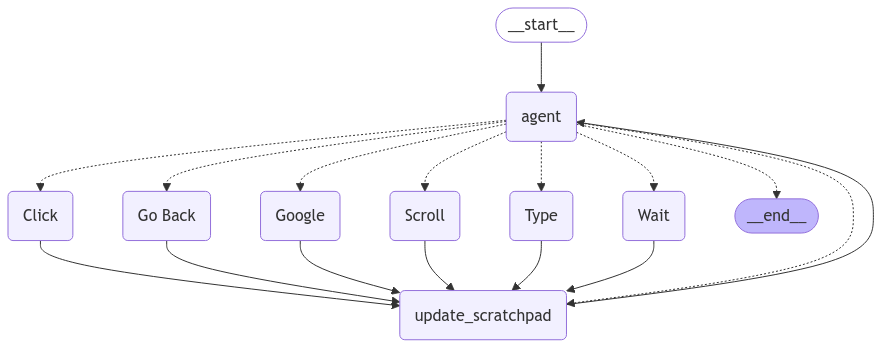

In [23]:
from langchain_core.runnables import RunnableLambda
from langgraph.graph import START, END, StateGraph
from IPython.display import display, Image

builder = StateGraph(AgentState)
builder.add_node("agent", agent)
builder.add_node("update_scratchpad", update_scratchpad)

builder.add_edge(START, "agent")
builder.add_conditional_edges("agent", select_tool)

for node_name, tool in tools.items():
    builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda observation: {"observation": observation}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    builder.add_edge(node_name, "update_scratchpad")


builder.add_edge("update_scratchpad", "agent")

graph = builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))



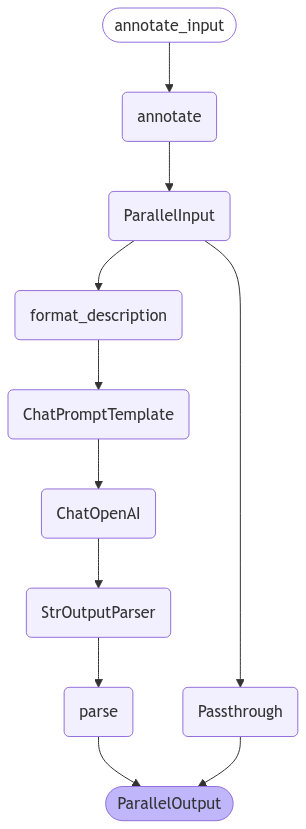

In [35]:
Image(agent.get_graph().draw_mermaid_png())

In [36]:
from IPython import display
from playwright.async_api import async_playwright

browser = await async_playwright().start()
# We will set headless=False so we can watch the agent navigate the web.
browser = await browser.chromium.launch(headless=False, args=None)
page = await browser.new_page()
_ = await page.goto("https://www.google.com")


async def call_agent(question: str, page, max_steps: int = 150):
    event_stream = graph.astream(
        {
            "page": page,
            "input": question,
            "scratchpad": [],
        },
        {
            "recursion_limit": max_steps,
        },
    )
    final_answer = None
    steps = []
    async for event in event_stream:
        # We'll display an event stream here
        if "agent" not in event:
            continue
        pred = event["agent"].get("prediction") or {}
        action = pred.get("action")
        action_input = pred.get("args")
        display.clear_output(wait=False)
        steps.append(f"{len(steps) + 1}. {action}: {action_input}")
        print("\n".join(steps))
        display.display(display.Image(base64.b64decode(event["agent"]["img"])))
        if "ANSWER" in action:
            final_answer = action_input[0]
            break
    return final_answer

In [37]:
res = await call_agent(
    "Please explain the today's XKCD comic for me. Why is it funny?", page
)
print(f"Final response: {res}")

KeyError: "Input to ChatPromptTemplate is missing variables {'bbox_descriptions'}.  Expected: ['bbox_descriptions', 'img', 'input'] Received: ['page', 'input', 'scratchpad', 'img', 'bboxes', 'bboxes_description']\nNote: if you intended {bbox_descriptions} to be part of the string and not a variable, please escape it with double curly braces like: '{{bbox_descriptions}}'.\nFor troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_PROMPT_INPUT "

In [2]:
from langchain_openai import ChatOpenAI
system_prompt= """Imagine you are a robot browsing the web, just like humans. Now you need to complete a task. In each iteration,
you will receive an Observation that includes a screenshot of a webpage and some texts. 
Carefully analyze the bounding box information and the web page contents to identify the Numerical Label corresponding 
to the Web Element that requires interaction, then follow
the guidelines and choose one of the following actions:

1. Click a Web Element.
2. Delete existing content in a textbox and then type content.
3. Scroll up or down.
4. Wait 
5. Go back
7. Return to google to start over.
8. Respond with the final answer

Correspondingly, Action should STRICTLY follow the format:

- Click [Numerical_Label] 
- Type [Numerical_Label]; [Content] 
- Scroll [Numerical_Label or WINDOW]; [up or down] 
- Wait 
- GoBack
- Bing
- ANSWER; [content]

Key Guidelines You MUST follow:

* Action guidelines *
1) Execute only one action per iteration.
2) Always click close on the popups.
3) When clicking or typing, ensure to select the correct bounding box.
4) Numeric labels lie in the top-left corner of their corresponding bounding boxes and are colored the same.
5) If the desired target is to do something like taking a action, you need to answer with ANSWER; FINISHED. For exmaple if i ask to write something or play a video

* Web Browsing Guidelines *
1) Don't interact with useless web elements like Login, Sign-in, donation that appear in Webpages
2) Select strategically to minimize time wasted.

Your reply should strictly follow the format:

Thought: {{Your brief thoughts (briefly summarize the info that will help ANSWER)}}
Action: {{One Action format you choose}}
Then the User will provide:
Observation: {{A labeled bounding boxes and contents given by User}}"

Observation including a screenshot of a webpage with bounding boxes and the text related to it: {result}"""


In [3]:
from langchain_core.prompts import ChatPromptTemplate

async def prompt_definition():   

    print("***************PROMPT_DEFINITION***************\n")
    template = """You are a web-browsing robot. You see a webpage with various labeled bounding boxes. 
    Each bounding box has a **Numerical Label** in the top-left corner, which identifies an interactive element. 

    Your goal is to handle the **User's Input** by analyzing the webpage's bounding boxes and deciding on **one** of the 
    following Actions to perform **per iteration**:

    1. Click a Web Element.
    2. Delete existing content in a textbox and then type content.
    3. Scroll up or down.
    4. Wait 
    5. Go back
    7. Return to google to start over.
    8. Respond with the final answer

    **Important Guidelines**:
    1. **Close popups** if they appear by clicking on the bounding box for the "close" button.  
    2. If the User wants to search something (like "NVIDIA Stock forecast"), you should **Type** the query into the Google 
    search bar bounding box.  
    3. Do **not** use "Bing" unless explicitly instructed.  
    4. If you must produce a final answer (e.g., if the user says "Please give me the final answer now"), use 
    **ANSWER; [content]**.  
    5. Properly define the concise search query or terms you need to type in search bar or any input field.

    **Action Format** must be exactly one of:
    - `Click [Numerical_Label]`
    - `Type [Numerical_Label]; [Content]`
    - `Scroll [Numerical_Label or WINDOW]; [up or down]`
    - `Wait`
    - `GoBack`
    - `ANSWER; [content]`

    ### Example

    If the user says "NVIDIA Stock forecast," and the bounding box for the Google search bar is labeled 2, you might respond:

    Thought: The user wants me to search for NVIDIA Stock forecast in Google. Action: Type [2]; NVIDIA Stock forecast


    -----

    **Now, here is the format of your output to the user**:
    1. Thought: a short text describing your reasoning about the next action.\\n
    2. Action: the single action you decide to take, in one of the required formats above.

    -----

    Observation (the screenshot, bounding boxes, etc.): {{result}}"""

    prompt = ChatPromptTemplate(
        messages=[
            ("system", template),
            ("placeholder", "{updated_notes}"),
            ("human", "Image: {image}"),
            ("human", "Bounding Boxes: {bboxes}"),
            ("human", "Input: {input}")
        ],
        input_variables=["image", "bboxes", "input"],
        partial_variables={"updated_notes": []},
        optional_variables=["updated_notes"]
    )
    
    return prompt

    #updated_notes = ["Some notes"]
    #image = state["image"]
    #bbox_descriptions = state["bbox_descriptions"]
    #input = "NVIDIA Stock forecast"
    #bboxes = state["bboxes"]

    #prompt_value = prompt.invoke({"updated_notes": updated_notes, "image": image, "bboxes": bboxes, "input": input})
    #print(prompt_value)
    #print("***************PROMPT_DEFINITION_DONE***************\n")
    #return prompt_value



In [6]:
prompt

ChatPromptTemplate(input_variables=['bboxes', 'image', 'input'], optional_variables=['updated_notes'], input_types={'updated_notes': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag=